<a href="https://colab.research.google.com/github/RMottram/2D-CNN/blob/master/2D_CNN_COLAB_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz


In [1]:
!nvidia-smi

Sat Aug  7 09:08:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# !unzip /content/drive/MyDrive/Colab\ Notebooks/64x64.zip > /dev/null
# !unzip /content/drive/MyDrive/Colab\ Notebooks/32x32.zip > /dev/null
!unzip /content/drive/MyDrive/Colab\ Notebooks/split_images.zip > /dev/null

In [5]:
## libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import sys, os, time, csv, glob, cv2, random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Convolution1D, Convolution2D, MaxPooling2D, Flatten, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils.np_utils import to_categorical

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, plot_confusion_matrix
from sklearn import metrics

## Settings
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.5f}'.format
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision = 5, suppress = True)

# CNN 1.0 - Binary output (attack/normal)

In [119]:
train_normal = []
test_normal = []
train_smurf = []
test_smurf = []
train_ip = []
test_ip = []
train_port = []
test_port = []
train_nmap = []
test_nmap = []

for i in glob.glob('/content/split_images/32x32_V2/70-30/train_normal/train_normal_equ_*.jpg', recursive=True):
    train_normal.append(cv2.imread(i, cv2.IMREAD_GRAYSCALE))

for j in glob.glob('/content/split_images/32x32_V2/70-30/test_normal/test_normal_equ_*.jpg', recursive=True):
    test_normal.append(cv2.imread(j, cv2.IMREAD_GRAYSCALE))

for k in glob.glob('/content/split_images/32x32_V2/70-30/train_smurf/train_smurf_equ_*.jpg', recursive=True):
    train_smurf.append(cv2.imread(k, cv2.IMREAD_GRAYSCALE))

for l in glob.glob('/content/split_images/32x32_V2/70-30/test_smurf/test_smurf_equ_*.jpg', recursive=True):
    test_smurf.append(cv2.imread(l, cv2.IMREAD_GRAYSCALE))

for m in random.sample(glob.glob('/content/split_images/32x32_V2/70-30/train_ip/train_ip_equ_*.jpg', recursive=True), 5998):
    train_ip.append(cv2.imread(m, cv2.IMREAD_GRAYSCALE))

for n in random.sample(glob.glob('/content/split_images/32x32_V2/70-30/test_ip/test_ip_equ_*.jpg', recursive=True), 2570):
    test_ip.append(cv2.imread(n, cv2.IMREAD_GRAYSCALE))
    
for o in random.sample(glob.glob('/content/split_images/32x32_V2/70-30/train_port/train_port_equ_*.jpg', recursive=True), 5998):
    train_port.append(cv2.imread(o, cv2.IMREAD_GRAYSCALE))

for p in random.sample(glob.glob('/content/split_images/32x32_V2/70-30/test_port/test_port_equ_*.jpg', recursive=True), 2570):
    test_port.append(cv2.imread(p, cv2.IMREAD_GRAYSCALE))
    
for q in glob.glob('/content/split_images/32x32_V2/70-30/train_nmap/train_nmap_equ_*.jpg', recursive=True):
    train_nmap.append(cv2.imread(q, cv2.IMREAD_GRAYSCALE))

for r in glob.glob('/content/split_images/32x32_V2/70-30/test_nmap/test_nmap_equ_*.jpg', recursive=True):
    test_nmap.append(cv2.imread(r, cv2.IMREAD_GRAYSCALE))
    


train_normal = np.array(train_normal)
test_normal = np.array(test_normal)
train_smurf = np.array(train_smurf)
test_smurf = np.array(test_smurf)
train_ip = np.array(train_ip)
test_ip = np.array(test_ip)
train_port = np.array(train_port)
test_port = np.array(test_port)
train_nmap = np.array(train_nmap)
test_nmap = np.array(test_nmap)

In [155]:
print(f'Normal train\t{np.shape(train_normal)}\nNormal test\t{np.shape(test_normal)}\nSmurf train\t{np.shape(train_smurf)}\nSmurf test\t{np.shape(test_smurf)}\nIP train\t{np.shape(train_ip)}\nIP test\t\t{np.shape(test_ip)}')
print(f'Port train\t{np.shape(train_port)}\nPort test\t{np.shape(test_port)}\nNmap train\t{np.shape(train_nmap)}\nNmap test\t{np.shape(test_nmap)}')

Normal train	(5997, 32, 32)
Normal test	(2571, 32, 32)
Smurf train	(425, 32, 32)
Smurf test	(183, 32, 32)
IP train	(5998, 32, 32)
IP test		(2570, 32, 32)
Port train	(5998, 32, 32)
Port test	(2570, 32, 32)
Nmap train	(224, 32, 32)
Nmap test	(96, 32, 32)


In [158]:
## augmenting the data to create more images
## only run cell if needed

## vertically flip training images
vert_flip_train_normal = np.fliplr(train_normal)
vert_flip_train_smurf = np.fliplr(train_smurf)
vert_flip_train_ip = np.fliplr(train_ip)
vert_flip_train_port = np.fliplr(train_port)
vert_flip_train_nmap = np.fliplr(train_nmap)

## flip training images horizonatally
hor_flip_train_normal = np.rot90(train_normal, axes = (1,2), k = 2)
hor_flip_train_smurf = np.rot90(train_smurf, axes = (1,2), k = 2)
hor_flip_train_ip = np.rot90(train_ip, axes = (1,2), k = 2)
hor_flip_train_port = np.rot90(train_port, axes = (1,2), k = 2)
hor_flip_train_nmap = np.rot90(train_nmap, axes = (1,2), k = 2)

## rotate training images left and right once each
# rotate90l_train_normal = np.rot90(train_normal, axes=(1, 2))
# rotate90r_train_normal = np.rot90(train_normal, -1, axes=(1, 2))
# rotate90l_train_smurf = np.rot90(train_smurf, axes=(1, 2))
# rotate90r_train_smurf = np.rot90(train_smurf, -1, axes=(1, 2))
# rotate90l_train_ip = np.rot90(train_ip, axes=(1, 2))
# rotate90r_train_ip = np.rot90(train_ip, -1, axes=(1, 2))
# rotate90l_train_port = np.rot90(train_port, axes=(1, 2))
# rotate90r_train_port = np.rot90(train_port, -1, axes=(1, 2))
# rotate90l_train_nmap = np.rot90(train_nmap, axes=(1, 2))
# rotate90r_train_nmap = np.rot90(train_nmap, -1, axes=(1, 2))





## vertically flip testing images
vert_flip_test_normal = np.fliplr(test_normal)
vert_flip_test_smurf = np.fliplr(test_smurf)
vert_flip_test_ip = np.fliplr(test_ip)
vert_flip_test_port = np.fliplr(test_port)
vert_flip_test_nmap = np.fliplr(test_nmap)

## flip testing images horizonatally
hor_flip_test_normal = np.rot90(test_normal, axes = (1,2), k = 2)
hor_flip_test_smurf = np.rot90(test_smurf, axes = (1,2), k = 2)
hor_flip_test_ip = np.rot90(test_ip, axes = (1,2), k = 2)
hor_flip_test_port = np.rot90(test_port, axes = (1,2), k = 2)
hor_flip_test_nmap = np.rot90(test_nmap, axes = (1,2), k = 2)

## rotate testing images left and right once each
# rotate90l_test_normal = np.rot90(test_normal, axes=(1, 2))
# rotate90r_test_normal = np.rot90(test_normal, -1, axes=(1, 2))
# rotate90l_test_smurf = np.rot90(test_smurf, axes=(1, 2))
# rotate90r_test_smurf = np.rot90(test_smurf, -1, axes=(1, 2))
# rotate90l_test_ip = np.rot90(test_ip, axes=(1, 2))
# rotate90r_test_ip = np.rot90(test_ip, -1, axes=(1, 2))
# rotate90l_test_port = np.rot90(test_port, axes=(1, 2))
# rotate90r_test_port = np.rot90(test_port, -1, axes=(1, 2))
# rotate90l_test_nmap = np.rot90(test_nmap, axes=(1, 2))
# rotate90r_test_nmap = np.rot90(test_nmap, -1, axes=(1, 2))


## stack all the original and augmented data to one single numpy array
# train = np.vstack((train_normal, vert_flip_train_normal, hor_flip_train_normal, rotate90l_train_normal, rotate90r_train_normal, train_ip, vert_flip_train_ip, hor_flip_train_ip, rotate90l_train_ip, rotate90r_train_ip, train_port, vert_flip_train_port, hor_flip_train_port, rotate90l_train_port, rotate90r_train_port))
# test = np.vstack((test_normal, vert_flip_test_normal, hor_flip_test_normal, rotate90l_test_normal, rotate90r_test_normal, test_ip, vert_flip_test_ip, hor_flip_test_ip, rotate90l_test_ip, rotate90r_test_ip, test_port, vert_flip_test_port, hor_flip_test_port, rotate90l_test_port, rotate90r_test_port))

train = np.vstack((train_normal, vert_flip_train_normal, hor_flip_train_normal, train_port, vert_flip_train_port, hor_flip_train_port))
test = np.vstack((test_normal, vert_flip_test_normal, hor_flip_test_normal, test_port, vert_flip_test_port, hor_flip_test_port))

In [121]:
## if no augmented data is needed, run this cell
train = np.vstack((train_normal, train_ip))
test = np.vstack((test_normal, test_ip))

train.shape, test.shape

((11995, 32, 32), (5141, 32, 32))

In [159]:
train = train.reshape(-1,32,32,1)
test = test.reshape(-1,32,32,1)

train.shape, test.shape

((35985, 32, 32, 1), (15423, 32, 32, 1))

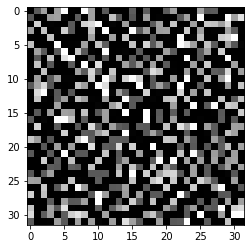

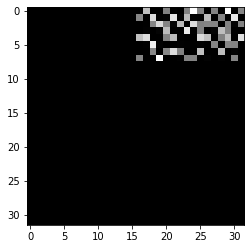

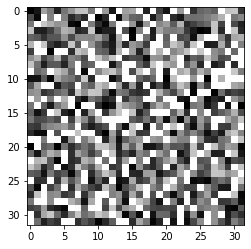

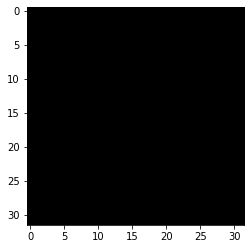

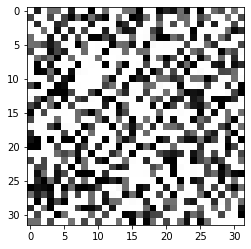

In [18]:
for i in range(0, 5):
    plt.imshow(tf.squeeze(train[i]), cmap = 'gray')
    plt.show()

In [123]:
## create the training and testing data labels
## run if not using augmented data

training_labels = []

for i in range(0, train_normal.shape[0]):
    training_labels.append('Normal')

# for j in range(0, train_smurf.shape[0]):
#     training_labels.append('Smurf-DDoS')
    
for k in range(0, train_ip.shape[0]):
    training_labels.append('IP-Sweep')
    
# for l in range(0, train_port.shape[0]):
#     training_labels.append('Port-Sweep')
    
# for m in range(0, train_nmap.shape[0]):
#     training_labels.append('Nmap-Sweep')



testing_labels = []

for i in range(0, test_normal.shape[0]):
    testing_labels.append('Normal')

# for j in range(0, test_smurf.shape[0]):
#     testing_labels.append('Smurf-DDoS')
    
for k in range(0, test_ip.shape[0]):
    testing_labels.append('IP-Sweep')
    
# for l in range(0, test_port.shape[0]):
#     testing_labels.append('Port-Sweep')
    
# for m in range(0, test_nmap.shape[0]):
#     testing_labels.append('Nmap-Sweep')

In [124]:
pd.DataFrame(training_labels)

,0
0,Normal
1,Normal
2,Normal
3,Normal
4,Normal
...,...
11990,IP-Sweep
11991,IP-Sweep
11992,IP-Sweep
11993,IP-Sweep


In [ ]:
## create the training and testing data labels
## run this cell if using augmented data with rotated data

training_labels = []

for i in range(0, train_normal.shape[0] + vert_flip_train_normal.shape[0] + hor_flip_train_normal.shape[0] + rotate90l_train_normal.shape[0] + rotate90r_train_normal.shape[0]):
    training_labels.append('Normal')

# for j in range(0, train_smurf.shape[0] + vert_flip_train_smurf.shape[0] + hor_flip_train_smurf.shape[0] + rotate90l_train_smurf.shape[0] + rotate90r_train_smurf.shape[0]):
#     training_labels.append('Smurf-DDoS')
    
for k in range(0, train_ip.shape[0] + vert_flip_train_ip.shape[0] + hor_flip_train_ip.shape[0] + rotate90l_train_ip.shape[0] + rotate90r_train_ip.shape[0]):
    training_labels.append('IP-Sweep')
    
for l in range(0, train_port.shape[0] + vert_flip_train_port.shape[0] + hor_flip_train_port.shape[0] + rotate90l_train_port.shape[0] + rotate90r_train_port.shape[0]):
    training_labels.append('Port-Sweep')
    
# for m in range(0, train_nmap.shape[0] + vert_flip_train_nmap.shape[0] + hor_flip_train_nmap.shape[0] + rotate90l_train_nmap.shape[0] + rotate90r_train_nmap.shape[0]):
#     training_labels.append('Nmap-Sweep')



testing_labels = []

for i in range(0, test_normal.shape[0] + vert_flip_test_normal.shape[0] + hor_flip_test_normal.shape[0] + rotate90l_test_normal.shape[0] + rotate90r_test_normal.shape[0]):
    testing_labels.append('Normal')

# for j in range(0, test_smurf.shape[0] + vert_flip_test_smurf.shape[0] + hor_flip_test_smurf.shape[0] + rotate90l_test_smurf.shape[0] + rotate90r_test_smurf.shape[0]):
#     testing_labels.append('Smurf-DDoS')
    
for k in range(0, test_ip.shape[0] + vert_flip_test_ip.shape[0] + hor_flip_test_ip.shape[0] + rotate90l_test_ip.shape[0] + rotate90r_test_ip.shape[0]):
    testing_labels.append('IP-Sweep')
    
for l in range(0, test_port.shape[0] + vert_flip_test_port.shape[0] + hor_flip_test_port.shape[0] + rotate90l_test_port.shape[0] + rotate90r_test_port.shape[0]):
    testing_labels.append('Port-Sweep')
    
# for m in range(0, test_nmap.shape[0] + vert_flip_test_nmap.shape[0] + hor_flip_test_nmap.shape[0] + rotate90l_test_nmap.shape[0] + rotate90r_test_nmap.shape[0]):
#     testing_labels.append('Nmap-Sweep')

In [160]:
## create the training and testing data labels
## run this cell if using augmented data and not with rotated data

training_labels = []

for i in range(0, train_normal.shape[0] + vert_flip_train_normal.shape[0] + hor_flip_train_normal.shape[0]):
    training_labels.append('Normal')

# for j in range(0, train_smurf.shape[0] + vert_flip_train_smurf.shape[0] + hor_flip_train_smurf.shape[0]):
#     training_labels.append('Smurf-DDoS')
    
# for k in range(0, train_ip.shape[0] + vert_flip_train_ip.shape[0] + hor_flip_train_ip.shape[0]):
#     training_labels.append('IP-Sweep')
    
for l in range(0, train_port.shape[0] + vert_flip_train_port.shape[0] + hor_flip_train_port.shape[0]):
    training_labels.append('Port-Sweep')
    
# for m in range(0, train_nmap.shape[0] + vert_flip_train_nmap.shape[0] + hor_flip_train_nmap.shape[0]):
#     training_labels.append('Nmap-Sweep')



testing_labels = []

for i in range(0, test_normal.shape[0] + vert_flip_test_normal.shape[0] + hor_flip_test_normal.shape[0]):
    testing_labels.append('Normal')

# for j in range(0, test_smurf.shape[0] + vert_flip_test_smurf.shape[0] + hor_flip_test_smurf.shape[0]):
#     testing_labels.append('Smurf-DDoS')
    
# for k in range(0, test_ip.shape[0] + vert_flip_test_ip.shape[0] + hor_flip_test_ip.shape[0]):
#     testing_labels.append('IP-Sweep')
    
for l in range(0, test_port.shape[0] + vert_flip_test_port.shape[0] + hor_flip_test_port.shape[0]):
    testing_labels.append('Port-Sweep')
    
# for m in range(0, test_nmap.shape[0] + vert_flip_test_nmap.shape[0] + hor_flip_test_nmap.shape[0]):
#     testing_labels.append('Nmap-Sweep')

In [161]:
## create the dataframe for labels, then OHE the column
ytrain = pd.DataFrame(training_labels, columns = ['category'])
ytest = pd.DataFrame(testing_labels, columns = ['category'])

ytrain = pd.get_dummies(ytrain['category'])
ytest = pd.get_dummies(ytest['category'])

ytrain, ytest

(       Normal  Port-Sweep
 0           1           0
 1           1           0
 2           1           0
 3           1           0
 4           1           0
 ...       ...         ...
 35980       0           1
 35981       0           1
 35982       0           1
 35983       0           1
 35984       0           1
 
 [35985 rows x 2 columns],        Normal  Port-Sweep
 0           1           0
 1           1           0
 2           1           0
 3           1           0
 4           1           0
 ...       ...         ...
 15418       0           1
 15419       0           1
 15420       0           1
 15421       0           1
 15422       0           1
 
 [15423 rows x 2 columns])

In [162]:
## shuffle the data to prevent pattern recognition
train, ytrain = sklearn.utils.shuffle(train, ytrain, random_state = 42)
test, ytest = sklearn.utils.shuffle(test, ytest, random_state = 42)

In [163]:
KERNEL_SIZE = [2,2]
IMAGE_SIZE = [32,32,1]

cnn = Sequential()

## convolution 1
cnn.add(Convolution2D(8, (KERNEL_SIZE), padding="same", activation='relu', input_shape = (IMAGE_SIZE)))
cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.25))

## convolution 2
cnn.add(Convolution2D(16, (KERNEL_SIZE), padding="same", activation='relu'))
cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.25))

## convolution 3
cnn.add(Convolution2D(32, (KERNEL_SIZE), padding="same", activation='relu'))
cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.25))

## convolution 4
cnn.add(Convolution2D(64, (KERNEL_SIZE), padding="same", activation='relu'))
cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.5))

## convolution 5
# cnn.add(Convolution2D(128, (KERNEL_SIZE), padding="same", activation='relu'))
# cnn.add(AveragePooling2D(pool_size = (2,2)))
# # cnn.add(Dropout(0.5))

# ## convolution 6
# cnn.add(Convolution2D(256, (KERNEL_SIZE), padding="same", activation='relu'))
# cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.5))

cnn.add(Flatten())

## dense
# cnn.add(Dense(256, activation='relu'))
# cnn.add(Dense(128, activation='relu'))
cnn.add(Dense(64, activation='relu'))
cnn.add(Dense(32, activation='relu'))
cnn.add(Dense(16, activation='relu'))
# cnn.add(Dropout(0.5))
cnn.add(Dense(2, activation = 'sigmoid'))

# callback = [EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 2)]

cnn.compile(optimizer = keras.optimizers.Adam(), loss = 'binary_crossentropy',
            metrics = ['accuracy'])


cnn.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_172 (Conv2D)          (None, 32, 32, 8)         40        
_________________________________________________________________
average_pooling2d_172 (Avera (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_173 (Conv2D)          (None, 16, 16, 16)        528       
_________________________________________________________________
average_pooling2d_173 (Avera (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_174 (Conv2D)          (None, 8, 8, 32)          2080      
_________________________________________________________________
average_pooling2d_174 (Avera (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_175 (Conv2D)          (None, 4, 4, 64)        

In [164]:
start = time.time()
model_history = cnn.fit(train, ytrain, batch_size = 128, epochs = 250)
end = time.time()

# os.system(f'say "training finished in {round(end - start, 2)} seconds"')
print(f'Training finished in {round(end - start, 2)}')

Epoch 1/250
282/282 [==============================] - 2s 5ms/step - loss: 0.5822 - accuracy: 0.6696
Epoch 2/250
282/282 [==============================] - 1s 5ms/step - loss: 0.5617 - accuracy: 0.6769
Epoch 3/250
282/282 [==============================] - 1s 5ms/step - loss: 0.5591 - accuracy: 0.6804
Epoch 4/250
282/282 [==============================] - 1s 5ms/step - loss: 0.5562 - accuracy: 0.6828
Epoch 5/250
282/282 [==============================] - 1s 5ms/step - loss: 0.5548 - accuracy: 0.6843
Epoch 6/250
282/282 [==============================] - 1s 5ms/step - loss: 0.5513 - accuracy: 0.6850
Epoch 7/250
282/282 [==============================] - 1s 5ms/step - loss: 0.5506 - accuracy: 0.6861
Epoch 8/250
282/282 [==============================] - 1s 5ms/step - loss: 0.5475 - accuracy: 0.6863
Epoch 9/250
282/282 [==============================] - 1s 5ms/step - loss: 0.5465 - accuracy: 0.6878
Epoch 10/250
282/282 [==============================] - 1s 5ms/step - loss: 0.5454 - accura

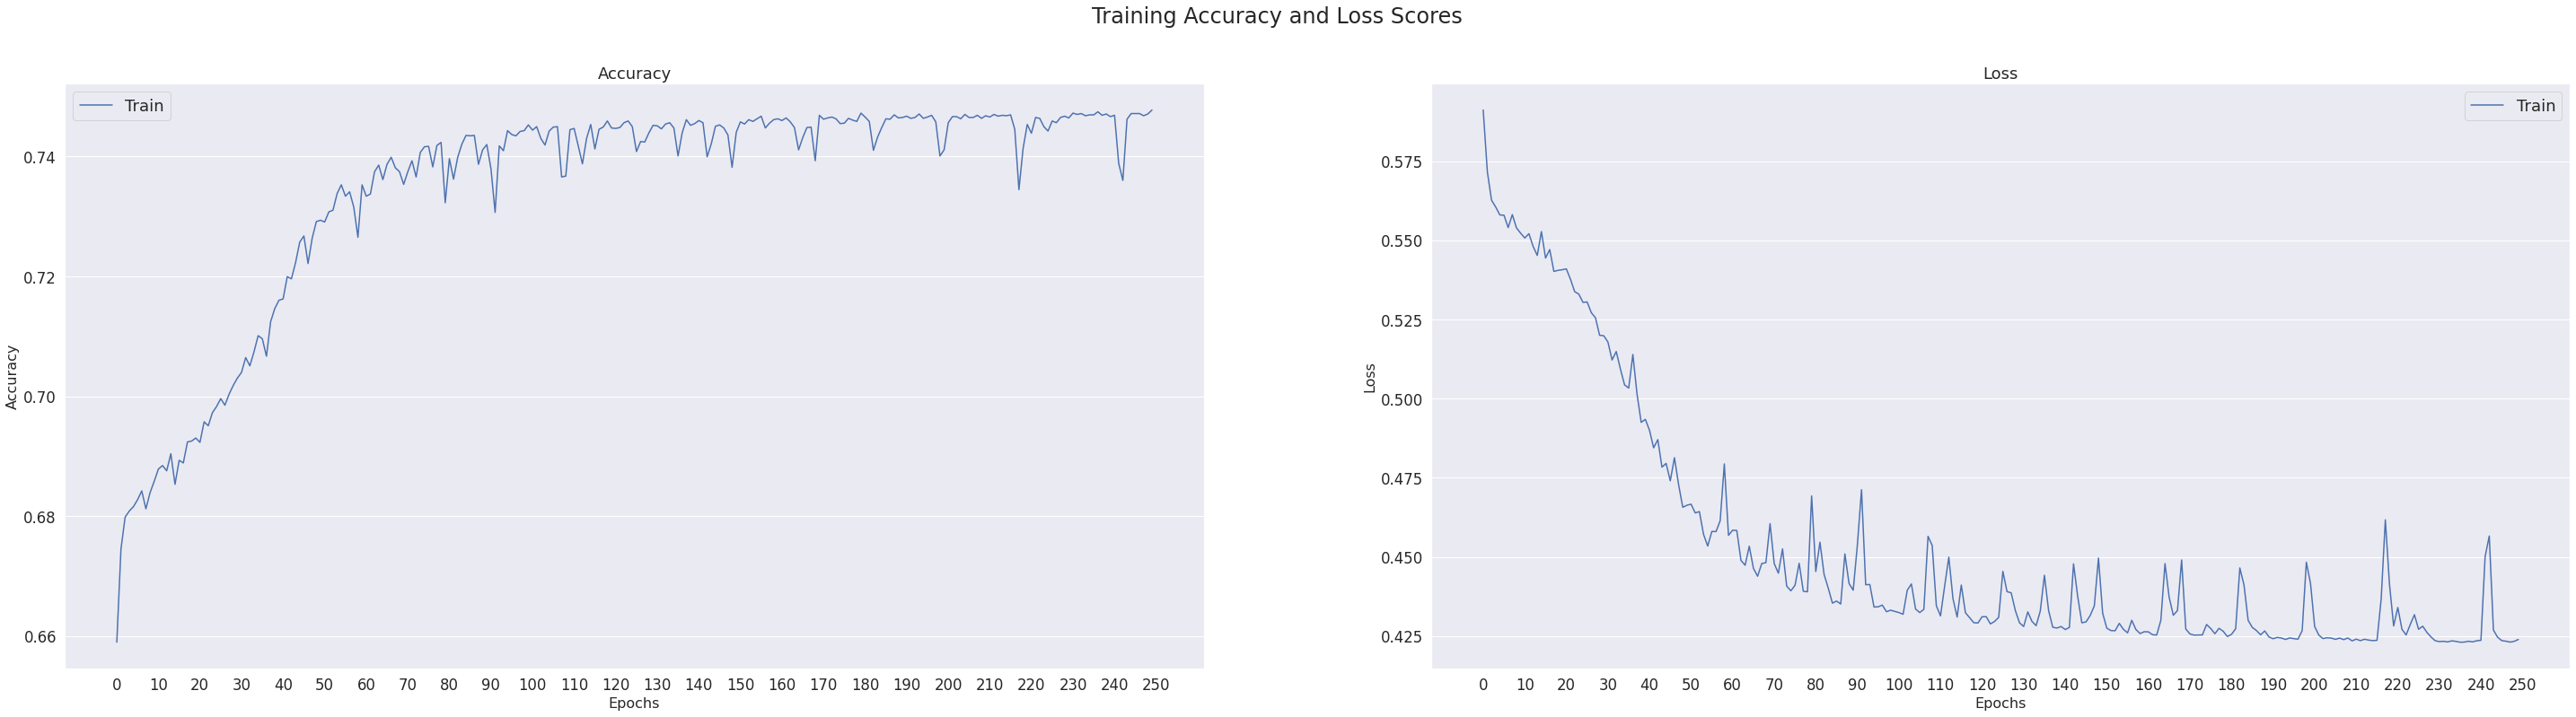

In [43]:
# print(model_history.history.keys())
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(50,12))
fig.suptitle('Training Accuracy and Loss Scores', fontsize = 24)

axes[0].plot(model_history.history['accuracy'])
axes[0].set_title('Accuracy', fontsize = 18)
axes[0].set_ylabel('Accuracy', fontsize = 16)
axes[0].set_xlabel('Epochs', fontsize = 16)
axes[0].set_xticks(np.arange(0, 260, step = 10))
axes[0].grid(axis = 'x')
axes[0].legend(['Train', 'Test'], loc = 'best', fontsize = 18)

axes[1].plot(model_history.history['loss'])
axes[1].set_title('Loss', fontsize = 18)
axes[1].set_ylabel('Loss', fontsize = 16)
axes[1].set_xlabel('Epochs', fontsize = 16)
axes[1].set_xticks(np.arange(0, 260, step = 10))
axes[1].grid(axis = 'x')
axes[1].legend(['Train', 'Test'], loc = 'best', fontsize = 18)

In [165]:
loss, acc = cnn.evaluate(test, ytest, batch_size = 128, verbose = 0)
print(f'Loss = {round(loss, 4)}\tAccuracy = {round(acc, 4)*100}%')

Loss = 1.0572	Accuracy = 67.67%


In [166]:
preds = (cnn.predict(test) > 0.5)
ypreds = np.argmax(test, axis = 1)

# label_enc = LabelEnco/transform(ytest)


# print('\tIP\tNmap\tNormal\tPort\tSmurf\n')
preds

array([[False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [ True, False],
       [ True, False],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [ True, False],
       [ True, False],
       [ True, False],
       [False,  True],
       [ True, False],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [ True, False],
       [ True, False],
       [ True, False],
       [False,  True],
       [False,  True],
       [ True, False],
       [False,  True],
       [False,  True],
       [ True, False],
       [False,  True],
       [False,  True],
       [False,  True],
       [ True, False],
       [False,  True],
       [ Tr

In [167]:
def build_classifier():
    
    cnn = Sequential()

    ## convolution 1
    cnn.add(Convolution2D(8, (KERNEL_SIZE), padding="same", activation='relu', input_shape = (IMAGE_SIZE)))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 2
    cnn.add(Convolution2D(16, (KERNEL_SIZE), padding="same", activation='relu'))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 3
    cnn.add(Convolution2D(32, (KERNEL_SIZE), padding="same", activation='relu'))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 4
    cnn.add(Convolution2D(64, (KERNEL_SIZE), padding="same", activation='relu'))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # # cnn.add(Dropout(0.5))

    ## convolution 5
    # cnn.add(Convolution2D(128, (KERNEL_SIZE), padding="same", activation='relu'))
    # cnn.add(AveragePooling2D(pool_size = (2,2)))
    # # # cnn.add(Dropout(0.5))

    # ## convolution 6
    # cnn.add(Convolution2D(128, (KERNEL_SIZE), padding="same", activation='relu'))
    # cnn.add(AveragePooling2D(pool_size = (2,2)))
    # # cnn.add(Dropout(0.5))

    cnn.add(Flatten())

    ## dense
    # cnn.add(Dense(256, activation='relu'))
    # cnn.add(Dense(128, activation='relu'))
    cnn.add(Dense(64, activation='relu'))
    cnn.add(Dense(32, activation='relu'))
    cnn.add(Dense(16, activation='relu'))
    # cnn.add(Dropout(0.5))
    cnn.add(Dense(2, activation = 'sigmoid'))

    # callback = [EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 2)]

    cnn.compile(optimizer = keras.optimizers.Adam(), loss = 'binary_crossentropy',
                metrics = ['accuracy'])
    
    return cnn

classifier = KerasClassifier(build_fn = build_classifier, batch_size = 128, epochs = 250)

In [168]:
from sklearn.model_selection import KFold

kf = KFold(n_splits = 5, random_state = None)
score = cross_val_score(classifier, test, ytest, cv = kf)
print(f'Model Cross Validation Score - {round(score.mean(), 3)*100}%')
print(f'Model Cross Validation Scores - {score}')
print(f'Model Cross Validation standard deviation - {round(score.std(), 3)*100}')

Epoch 1/250
97/97 [==============================] - 1s 6ms/step - loss: 0.5939 - accuracy: 0.6586
Epoch 2/250
97/97 [==============================] - 1s 5ms/step - loss: 0.5670 - accuracy: 0.6796
Epoch 3/250
97/97 [==============================] - 1s 5ms/step - loss: 0.5651 - accuracy: 0.6808
Epoch 4/250
97/97 [==============================] - 1s 5ms/step - loss: 0.5629 - accuracy: 0.6801
Epoch 5/250
97/97 [==============================] - 1s 5ms/step - loss: 0.5583 - accuracy: 0.6832
Epoch 6/250
97/97 [==============================] - 0s 5ms/step - loss: 0.5597 - accuracy: 0.6824
Epoch 7/250
97/97 [==============================] - 1s 5ms/step - loss: 0.5548 - accuracy: 0.6838
Epoch 8/250
97/97 [==============================] - 1s 5ms/step - loss: 0.5535 - accuracy: 0.6861
Epoch 9/250
97/97 [==============================] - 0s 5ms/step - loss: 0.5507 - accuracy: 0.6884
Epoch 10/250
97/97 [==============================] - 0s 5ms/step - loss: 0.5531 - accuracy: 0.6853
Epoch 11/

In [169]:
targets = ['Normal', 'Port']
cr = classification_report(ytest, preds, target_names=targets, zero_division=0)
cm = confusion_matrix(ytest.values.argmax(axis = 1), preds.argmax(axis = 1))

In [170]:
cm_df = pd.DataFrame(cm,
                     index = targets, 
                     columns = targets)

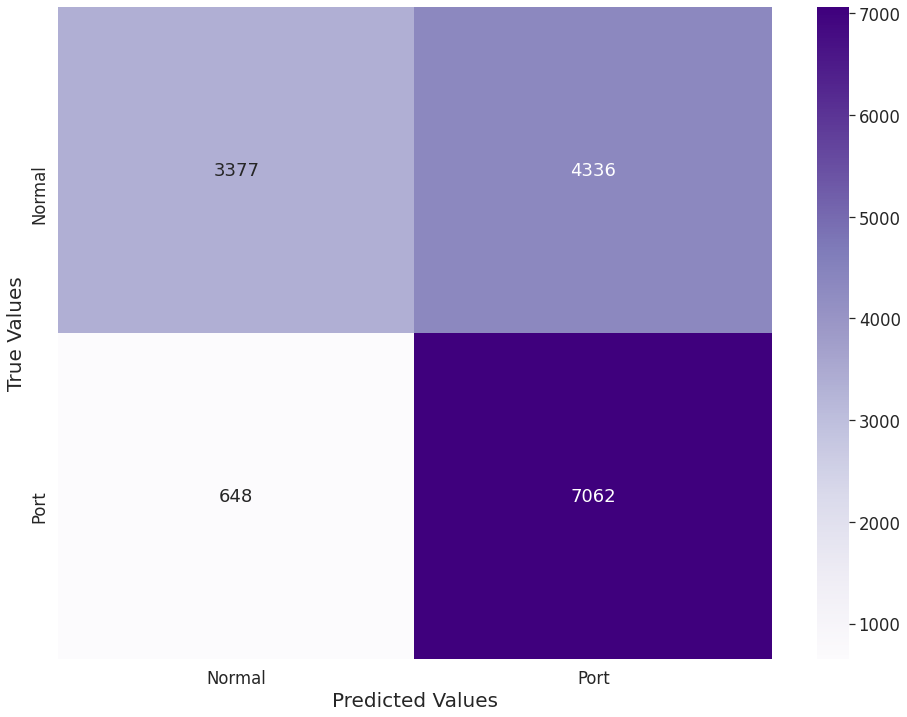

              precision    recall  f1-score   support

      Normal       0.84      0.44      0.57      7713
        Port       0.62      0.92      0.74      7710

   micro avg       0.68      0.68      0.68     15423
   macro avg       0.73      0.68      0.66     15423
weighted avg       0.73      0.68      0.66     15423
 samples avg       0.68      0.68      0.68     15423



In [171]:
plt.figure(figsize=(16,12))
sns.set(font_scale=1.5)
sns.heatmap(cm_df, annot=True, cmap = 'Purples', fmt='1')
plt.ylabel('True Values', fontsize = '20')
plt.xlabel('Predicted Values', fontsize = '20')
plt.show()

print(cr)

In [172]:
def perf_measure(y_actual, y_pred, labels):
    labels = targets
    class_id = set(y_actual).union(set(y_pred))
    TP = []
    FP = []
    TN = []
    FN = []

    for index ,_id in enumerate(class_id):
        TP.append(0)
        FP.append(0)
        TN.append(0)
        FN.append(0)
        for i in range(len(y_pred)):
            if y_actual[i] == y_pred[i] == _id:
                TP[index] += 1
            if y_pred[i] == _id and y_actual[i] != y_pred[i]:
                FP[index] += 1
            if y_actual[i] == y_pred[i] != _id:
                TN[index] += 1
            if y_pred[i] != _id and y_actual[i] != y_pred[i]:
                FN[index] += 1


    return(print(f'{labels}\nTP - {TP}\nFP - {FP}\nTN - {TN}\nFN - {FN}'))

In [173]:
perf_measure(ytest.values.argmax(axis = 1), preds.argmax(axis = 1), targets)

['Normal', 'Port']
TP - [3377, 7062]
FP - [648, 4336]
TN - [7062, 3377]
FN - [4336, 648]
